#**HYBRID MODEL: CNN + RNN**

Hybrid Model: In our study, we explored a hybrid model by combining a convolutional neural network (CNN) with a recurrent neural network (RNN) to effectively capture complex temporal patterns. This approach leverages the strengths of both networks, with the CNN acting as a feature extractor to identify critical patterns and trends in power consumption data over short time windows. These features are then passed to the RNN, which excels at learning temporal dependencies and sequence dynamics. At each time step, the CNN processes the data to extract key patterns, while the RNN utilizes this information to predict future power consumption, effectively capturing both local and long-term temporal relationships in the series.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
data = pd.read_csv('sorted_energy_data.csv', parse_dates=['Datetime'], index_col='Datetime')
data = data.sort_index()  # Ensure the data is sorted by datetime
print(data.head(10))  # Display first 10 rows to check data
df = data



In [2]:
import numpy as np
import pandas as pd
import sklearn.preprocessing

# Normalize Data (Min-Max Scaling)
def normalize_data(train_df, test_df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    train_df = train_df.copy()
    test_df = test_df.copy()
    train_df['NI_MW'] = scaler.fit_transform(train_df['NI_MW'].values.reshape(-1, 1))
    test_df['NI_MW'] = scaler.transform(test_df['NI_MW'].values.reshape(-1, 1))
    return train_df, test_df, scaler

# Function to create sequences
def load_data(stock, seq_len):
    X_data, y_data = [], []
    for i in range(seq_len, len(stock)):
        X_data.append(stock.iloc[i-seq_len:i].values)  # All columns for multivariate
        y_data.append(stock.iloc[i, 0])  # Target column (NI_MW)
    return np.array(X_data), np.array(y_data)

# Split into train and test
train_size = int(len(df) * 0.8)
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

# Normalize
train_data, test_data, scaler = normalize_data(train_data, test_data)

# Sequence length
seq_len = 24

# Create sequences
X_train, y_train = load_data(train_data, seq_len)
X_test, y_test = load_data(test_data, seq_len)

# Split into training and validation
val_size = int(len(X_train) * 0.2)
X_val, y_val = X_train[-val_size:], y_train[-val_size:]
X_train, y_train = X_train[:-val_size], y_train[:-val_size]

# Reshape for time-series models
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], -1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))

# Print shapes
print(f'X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}')
print(f'X_val.shape = {X_val.shape}, y_val.shape = {y_val.shape}')
print(f'X_test.shape = {X_test.shape}, y_test.shape = {y_test.shape}')


X_train.shape = (37389, 24, 1), y_train.shape = (37389,)
X_val.shape = (9347, 24, 1), y_val.shape = (9347,)
X_test.shape = (11666, 24, 1), y_test.shape = (11666,)


In [3]:

import matplotlib.pyplot as plt
import numpy as np
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import load_model

# Load the previously saved model
model_path = '/content/hybrid-model.h5'  # Replace with your model's file path
model = load_model(model_path)
# Evaluate the model on training and testing data
train_score = model.evaluate(X_train, y_train, verbose=0)
test_score = model.evaluate(X_test, y_test, verbose=0)

# Print MSE for both train and test sets
print(f'Train MSE: {train_score}, Test MSE: {test_score}')

# Make predictions
predictions = model.predict(X_test)

Train MSE: 0.00042575885890983045, Test MSE: 0.0004525891272351146
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [4]:
y_pred=predictions
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled=scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()


In [7]:
print(y_test_actual)

[[11967.]
 [11536.]
 [11668.]
 ...
 [10825.]
 [10511.]
 [10042.]]


In [12]:
x=y_test_actual.flatten()

In [8]:
print(y_pred_rescaled)

[11766.839 11584.605 11778.151 ... 11285.733 10933.274 10001.07 ]


In [16]:
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate the performance metrics
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mape = np.mean(np.abs((y_test_rescaled - y_pred_rescaled) / y_test_rescaled)) * 100
smape = 100 * np.mean(2 * np.abs(y_pred_rescaled - y_test_rescaled) / (np.abs(y_test_rescaled) + np.abs(y_pred_rescaled)))
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

# Print the results
print(f"LSTM: RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%, sMAPE: {smape:.2f}%, R²: {r2:.2f}")


LSTM: RMSE: 353.75, MAE: 247.46, MAPE: 2.11%, sMAPE: 2.11%, R²: 0.98


Rescaled Predictions: [11766.839 11584.605 11778.151 11853.354 11281.305]
Rescaled Actual Values: [[11967.]
 [11536.]
 [11668.]
 [11879.]
 [11241.]]


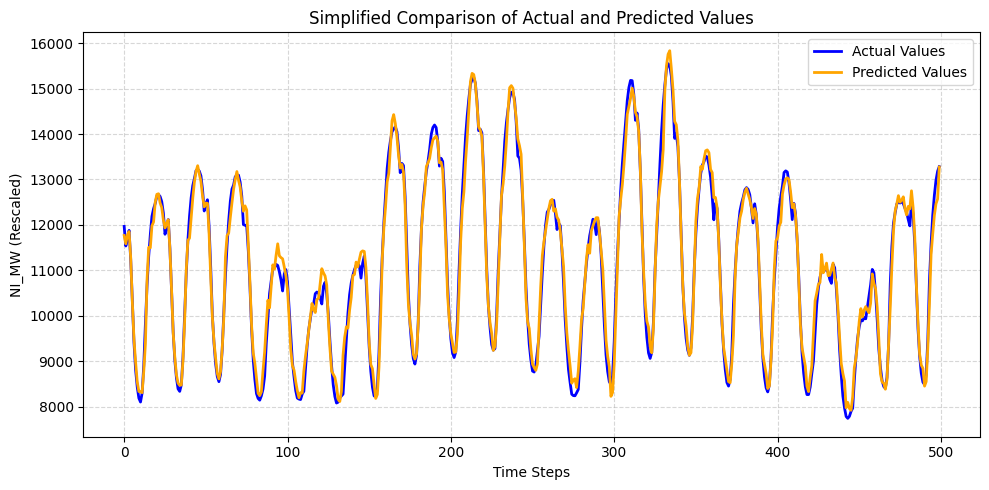

In [ ]:
# Print to verify the rescaling
print("Rescaled Predictions:", y_pred_rescaled[:5])
print("Rescaled Actual Values:", y_test_actual[:5])
import matplotlib.pyplot as plt

# Limit the data to the first 500 points for simplicity
subset = 500
y_pred_rescaled_subset = y_pred_rescaled[:subset]
y_test_actual_subset = y_test_actual[:subset]

# Plot the simplified graph
plt.figure(figsize=(10, 5))
plt.plot(y_test_actual_subset, label="Actual Values", color='blue', linewidth=2)
plt.plot(y_pred_rescaled_subset, label="Predicted Values", color='orange', linewidth=2)
plt.title("Simplified Comparison of Actual and Predicted Values")
plt.xlabel("Time Steps")
plt.ylabel("NI_MW (Rescaled)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


<ipython-input-19-80cba40d4c98>:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start='2010-01-01', periods=len(y_test_rescaled), freq='H')  # Example hourly timestamps


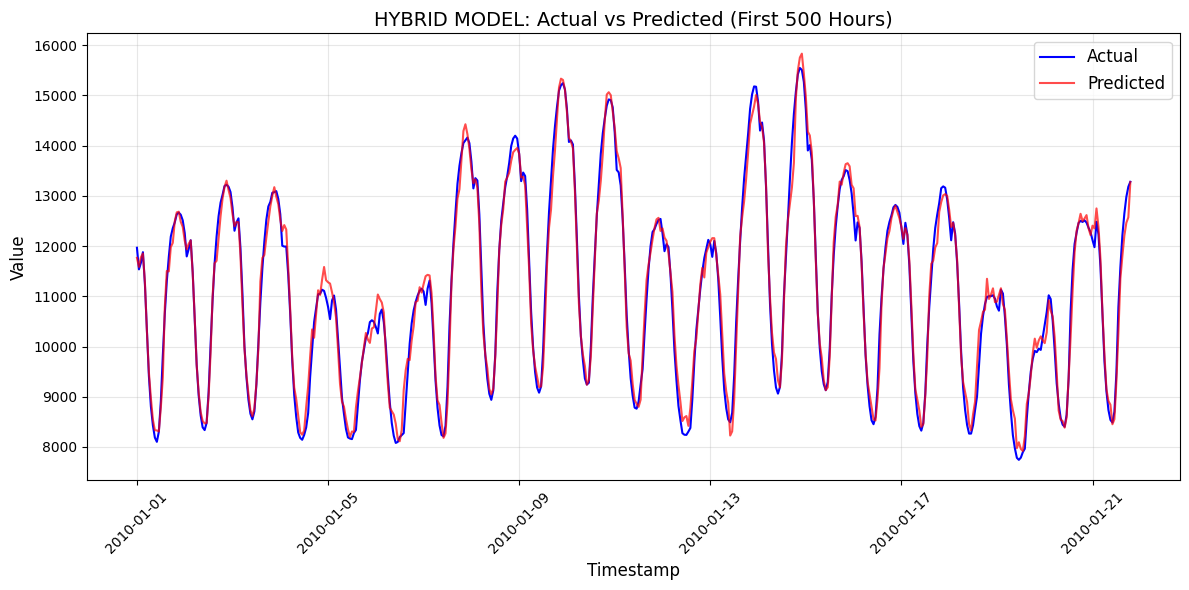

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Generate sample timestamps for the x-axis (adjust based on your actual data)
timestamps = pd.date_range(start='2010-01-01', periods=len(y_test_rescaled), freq='H')  # Example hourly timestamps

# If y_test and y_pred have different scales, rescale them to the original scale using the scaler
# y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
# y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Plot the first 500 points for visualization
plt.figure(figsize=(12, 6))
plt.plot(timestamps[:500], y_test_rescaled[:500], label='Actual', color='blue')
plt.plot(timestamps[:500], y_pred_rescaled[:500], label='Predicted', color='red', alpha=0.7)

# Customize the graph
plt.title("HYBRID MODEL: Actual vs Predicted (First 500 Hours)", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()
